### From one session, decode entropy (or max feature value)
- See if this is "abstract", generalizes well between different dimensions

In [12]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
from scipy import stats
import warnings
from scipy.ndimage import gaussian_filter1d

from sklearn.linear_model import (
    PoissonRegressor,
    LinearRegression,
    Ridge,
)
from sklearn.model_selection import (
    KFold,
    ShuffleSplit
)

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
SMOOTH = 1
num_bins = 10

In [14]:
def get_beh_fr(session):
    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    valid_beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(valid_beh)
    valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_feature_values_per_session(session, valid_beh)
    beh = behavioral_utils.get_relative_block_position(beh, num_bins)
    beh = behavioral_utils.get_max_feature_value(beh, num_bins)
    beh = behavioral_utils.calc_feature_probs(beh)
    beh = behavioral_utils.calc_feature_value_entropy(beh, num_bins)

    fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"

    frs = pd.read_pickle(fr_path)
    agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()
    agg = pd.merge(agg, beh[["TrialNumber", "BlockNumber"]], on="TrialNumber")
    agg = spike_utils.zscore_frs(agg, group_cols=["UnitID", "BlockNumber"], mode="FiringRate")
    agg = agg[agg.TrialNumber.isin(beh.TrialNumber)]
    return beh, agg

In [15]:

def get_regression_res(row, mode="FiringRate"):
    session = row.session_name
    beh, agg = get_beh_fr(session)
    

    agg = agg.sort_values(by=["TrialNumber", "UnitID"])
    # agg = agg[agg.UnitID == 2]

    num_trials = agg.TrialNumber.nunique()
    num_units = agg.UnitID.nunique()
    x = agg[mode].values.reshape(num_trials, num_units)
    y = beh.FeatEntropy.values

    model = LinearRegression()
    model = model.fit(x, y)
    train_score = model.score(x, y)
    row["EntropyScore"] = train_score
    row["NumBlocks"] = beh.BlockNumber.nunique()
    return row
# print(f"{session}: Entropy R^2: {train_score}")
# merged = spike_utils.zscore_frs(merged, group_cols=["UnitID", "BlockNumber"], mode="FiringRate")


In [16]:
def regress(beh, agg, train_trials, test_trials, mode="FiringRate"):
    train_agg = agg[agg.TrialNumber.isin(train_trials)]
    test_agg = agg[agg.TrialNumber.isin(test_trials)]

    train_beh = beh[beh.TrialNumber.isin(train_trials)]
    test_beh = beh[beh.TrialNumber.isin(test_trials)]

    num_units = agg.UnitID.nunique()
    train_agg = train_agg.sort_values(by=["TrialNumber", "UnitID"])
    train_x = train_agg[mode].values.reshape(len(train_trials), num_units)
    train_y = train_beh.MaxValue.values

    test_agg = test_agg.sort_values(by=["TrialNumber", "UnitID"])
    test_x = test_agg[mode].values.reshape(len(test_trials), num_units)
    test_y = test_beh.MaxValue.values

    model = LinearRegression()
    # model = Ridge(alpha=1)
    model = model.fit(train_x, train_y)
    train_score = model.score(train_x, train_y)
    test_score = model.score(test_x, test_y)

    return train_score, test_score, model

In [17]:
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)
res = sessions.apply(get_regression_res, axis=1)

In [18]:
res.sort_values(by="EntropyScore", ascending=False)

,session_datetime,session_count,session_name,valid,FE_abs_median,FD_abs_median,FRL_abs_median,FE_neg_median,FE_pos_median,EntropyScore,NumBlocks
104,2018-07-12,0.0,20180712,True,0.242642,0.235202,0.250000,-0.212700,0.260526,0.510751,14
79,2018-09-21,0.0,20180921,True,0.246361,0.233783,0.288174,-0.249467,0.241297,0.439312,31
55,2018-09-24,0.0,20180924,True,0.243970,0.234049,0.265687,-0.228124,0.255757,0.406627,33
43,2018-08-02,0.0,20180802,True,0.241787,0.237204,0.284283,-0.241726,0.241865,0.379877,53
93,2018-09-25,0.0,20180925,True,0.251318,0.240412,0.288771,-0.234125,0.274260,0.364552,32
39,2018-10-01,0.0,20181001,True,0.242593,0.227074,0.290301,-0.222050,0.274271,0.356525,27
5,2018-09-20,0.0,20180920,True,0.237037,0.229612,0.268988,-0.234586,0.246061,0.350277,30
27,2018-07-25,1.0,201807250001,True,0.260517,0.243805,0.255710,-0.217215,0.287453,0.347502,14
0,2018-07-09,0.0,20180709,True,0.226614,0.205048,0.241765,-0.250000,0.207856,0.344847,29
73,2018-10-03,0.0,20181003,True,0.233735,0.229121,0.258320,-0.199926,0.273177,0.339686,30


### 20180921 looks like a good session, evaluate abstractness

In [19]:
def block_splits(beh, agg, n_splits=20, test_size=0.66):
    blocks = beh.BlockNumber.unique()
    splitter = ShuffleSplit(n_splits=n_splits, test_size=test_size)
    block_train_scores = np.empty(n_splits)
    block_test_scores = np.empty(n_splits)
    # NOTE: atually want to train on 1/3, test on 2/3s, 
    # so still use KFold, but just switch train/test idxs
    for i, (test_idx, train_idx) in enumerate(splitter.split(blocks)):
        train_trials = beh[beh.BlockNumber.isin(blocks[train_idx])].TrialNumber
        test_trials = beh[beh.BlockNumber.isin(blocks[test_idx])].TrialNumber
        train_score, test_score, model = regress(beh, agg, train_trials, test_trials)
        block_train_scores[i] = train_score
        block_test_scores[i] = test_score
    return block_train_scores, block_test_scores

def dim_splits(beh, agg):
    dim_train_scores = np.empty(3)
    dim_test_scores = np.empty(3)

    kf = KFold(n_splits=3, shuffle=True)
    # NOTE: atually want to train on 1/3, test on 2/3s, 
    # so still use KFold, but just switch train/test idxs
    for i, (test_idxs, train_idxs) in enumerate(kf.split(FEATURE_DIMS)):
        train_dim = FEATURE_DIMS[train_idxs[0]]
        train_feats = POSSIBLE_FEATURES[train_dim]
        test_feats = np.concatenate([POSSIBLE_FEATURES[FEATURE_DIMS[idx]] for idx in test_idxs])
        train_trials = beh[beh.CurrentRule.isin(train_feats)].TrialNumber
        test_trials = beh[beh.CurrentRule.isin(test_feats)].TrialNumber
        train_score, test_score, model = regress(beh, agg, train_trials, test_trials)
        dim_train_scores[i] = train_score
        dim_test_scores[i] = test_score
    return dim_train_scores, dim_test_scores

def rule_split(beh, agg, rule):
    train_trials = beh[beh.CurrentRule == rule].TrialNumber
    test_trials = beh[beh.CurrentRule != rule].TrialNumber
    train_score, test_score, model = regress(beh, agg, train_trials, test_trials)
    return np.array([train_score]), np.array([test_score])



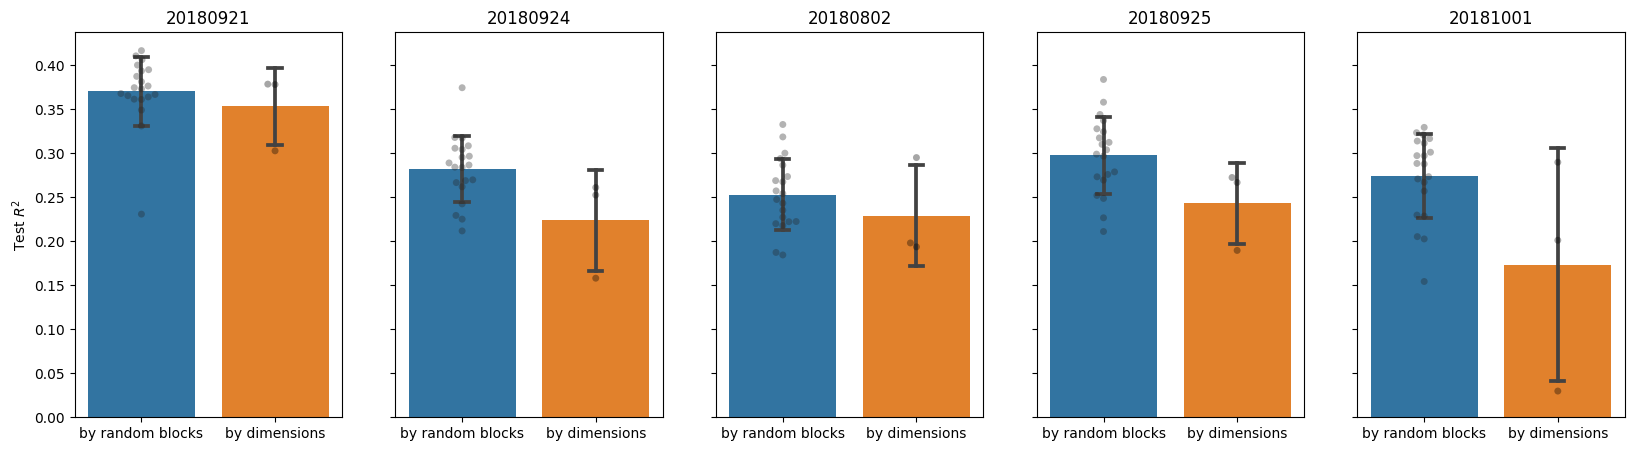

In [20]:
sesses = res.sort_values(by="EntropyScore", ascending=False)[1:6]
fig, axs = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

for i, (_, row) in enumerate(sesses.iterrows()):
    session = row.session_name
    beh, agg = get_beh_fr(session)

    _, block_test = block_splits(beh, agg)
    _, dim_test = dim_splits(beh, agg)

    counts = beh.groupby("CurrentRule").BlockNumber.nunique()
    freq_rule = counts.idxmax()
    num_rule_blocks = counts.max()
    _, rule_test = rule_split(beh, agg, freq_rule)

    ax = axs[i]
    # visualization_utils.visualize_accuracy_bars(
    #     [block_test, dim_test, rule_test], 
    #     ["by random blocks", "by dimensions", f"{freq_rule}, {num_rule_blocks} blocks"], ax)
    visualization_utils.visualize_accuracy_bars(
        [block_test, dim_test], 
        ["by random blocks", "by dimensions", ], ax)
    ax.set_ylabel("Test $R^2$")
    ax.set_title(session)

### What about using raw feature values?

In [21]:
fake_agg = beh[["TrialNumber"] + [f"{feat}Value" for feat in FEATURES]]
rename_map = {f"{feat}Value": i for i, feat in enumerate(FEATURES)}
fake_agg = fake_agg.rename(columns=rename_map)
fake_agg = pd.melt(fake_agg, id_vars=["TrialNumber"], value_vars=list(range(12)), var_name="UnitID", value_name="FiringRate")

In [22]:
fake_agg

,TrialNumber,UnitID,FiringRate
0,23,0,0.000000
1,24,0,0.000000
2,25,0,0.000000
3,26,0,0.000000
4,27,0,0.000000
...,...,...,...
11107,948,11,0.633587
11108,949,11,0.672539
11109,950,11,0.535197
11110,951,11,0.425902


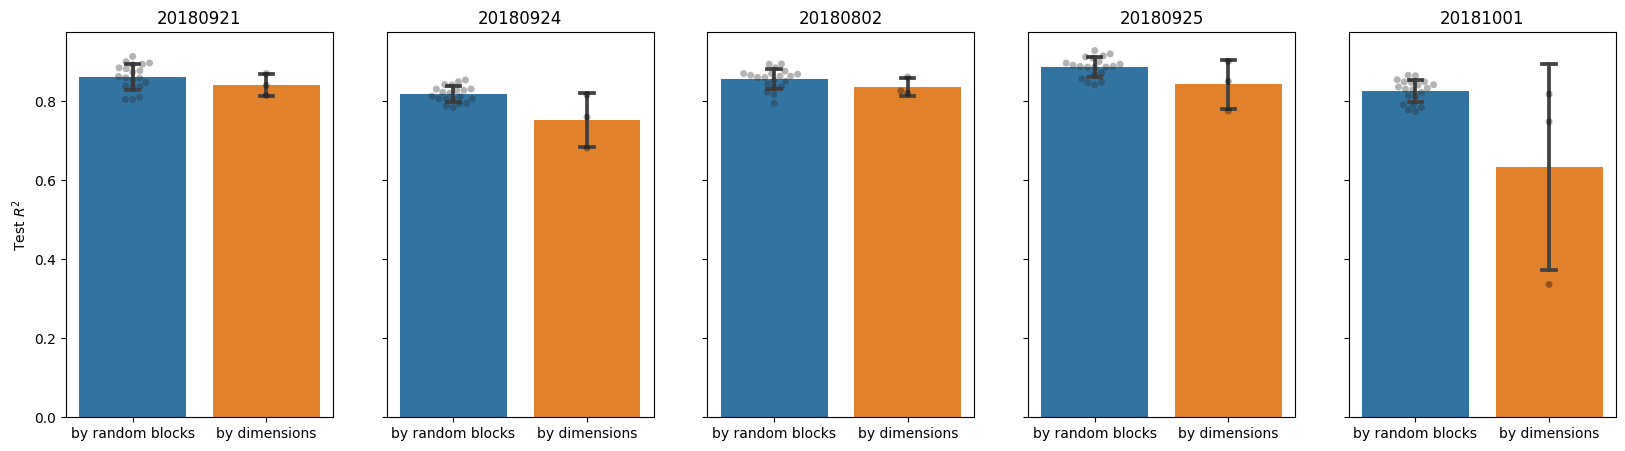

In [23]:
sesses = res.sort_values(by="EntropyScore", ascending=False)[1:6]
fig, axs = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

for i, (_, row) in enumerate(sesses.iterrows()):
    session = row.session_name
    
    beh, agg = get_beh_fr(session)
    fake_agg = beh[["TrialNumber"] + [f"{feat}Value" for feat in FEATURES]]
    rename_map = {f"{feat}Value": i for i, feat in enumerate(FEATURES)}
    fake_agg = fake_agg.rename(columns=rename_map)
    fake_agg = pd.melt(fake_agg, id_vars=["TrialNumber"], value_vars=list(range(12)), var_name="UnitID", value_name="FiringRate")

    _, block_test = block_splits(beh, fake_agg)
    _, dim_test = dim_splits(beh, fake_agg)


    ax = axs[i]
    # visualization_utils.visualize_accuracy_bars(
    #     [block_test, dim_test, rule_test], 
    #     ["by random blocks", "by dimensions", f"{freq_rule}, {num_rule_blocks} blocks"], ax)
    visualization_utils.visualize_accuracy_bars(
        [block_test, dim_test], 
        ["by random blocks", "by dimensions", ], ax)
    ax.set_ylabel("Test $R^2$")
    ax.set_title(session)

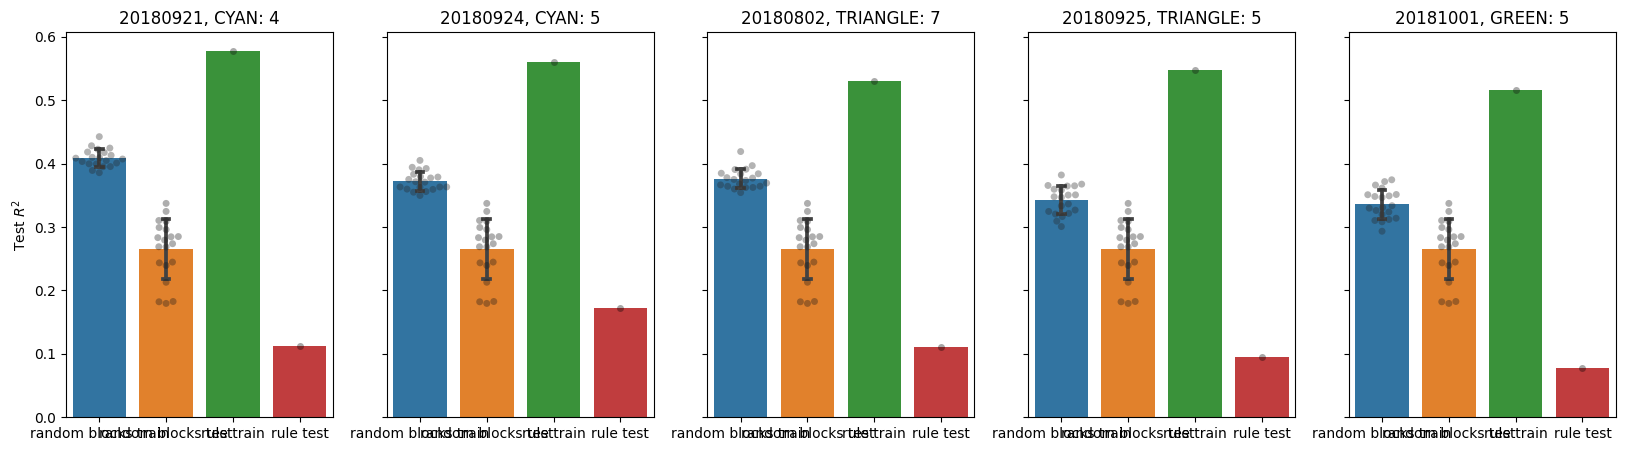

In [16]:
sesses = res.sort_values(by="EntropyScore", ascending=False)[1:6]
fig, axs = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

for i, (_, row) in enumerate(sesses.iterrows()):
    session = row.session_name
    beh, agg = get_beh_fr(session)



    counts = beh.groupby("CurrentRule").BlockNumber.nunique()
    rule = counts.idxmax()
    num_rule_blocks = counts.max()

    blocks_train, blocks_test = block_splits(beh, agg, 20, 1 - (num_rule_blocks / beh.CurrentRule.nunique()))
    rule_train, rule_test = rule_split(beh, agg, rule)

    ax = axs[i]
    visualization_utils.visualize_accuracy_bars(
        [blocks_train, block_test, rule_train, rule_test], 
        ["random blocks train", "random blocks test", "rule train", "rule test"], 
        ax=ax
    )
    ax.set_ylabel("Test $R^2$")
    ax.set_title(f"{session}, {rule}: {num_rule_blocks}")

### More rigorous approach: 
- Filter rules that occur at least N times (N = 2?)
- For each rule, train a decoder on Entropy, evaluate it against each other rule
- Get a cross-rule generalizability metric
- Shuffle rule labels, do the same

In [24]:
def get_rule_generalizability(beh, agg):
    across_rules = []
    good_rules = beh.CurrentRule.unique()
    for rule in good_rules: 
        other_rules = good_rules[good_rules != rule]
        # for other_rule in other_rules:
        train_trials = beh[beh.CurrentRule == rule].TrialNumber
        test_trials = beh[beh.CurrentRule != rule].TrialNumber
        train_score, test_score, model = regress(beh, agg, train_trials, test_trials)
        across_rules.append(test_score)
    return across_rules

20180921, 8
20180924, 5
20180802, 10
20180925, 6
20181001, 3


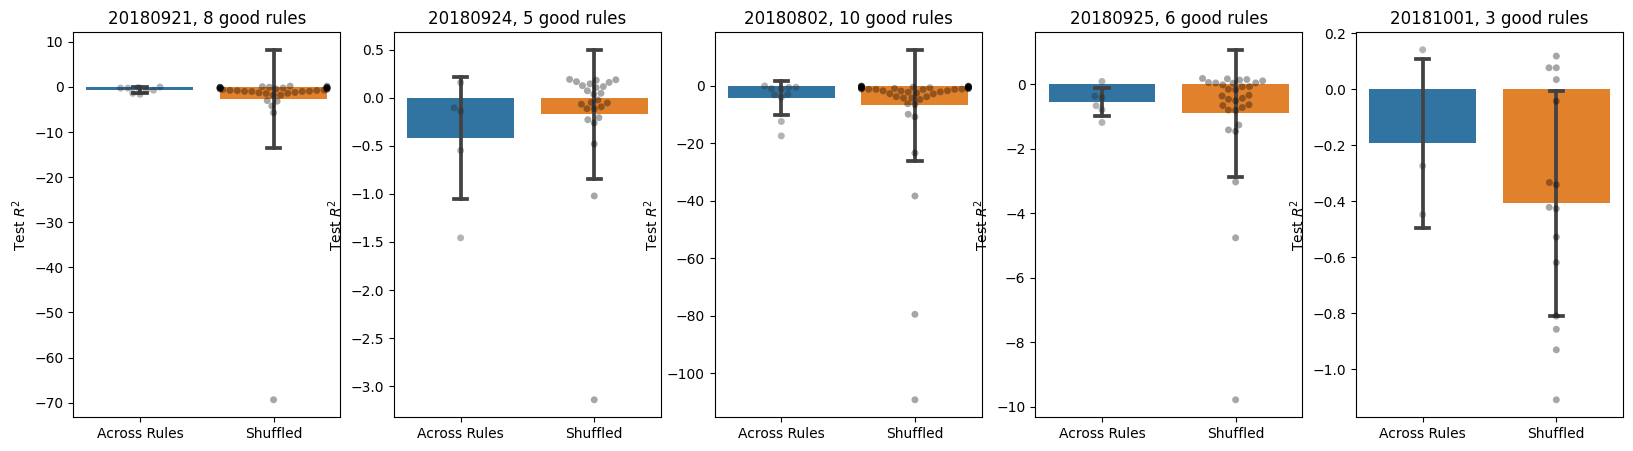

In [52]:
sesses = res.sort_values(by="EntropyScore", ascending=False)[1:6]
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

num_shuffles = 5
for i, (_, row) in enumerate(sesses.iterrows()):
    session = row.session_name
    beh, agg = get_beh_fr(session)
    beh = behavioral_utils.filter_max_feat_correct(beh)

    counts = beh.groupby("CurrentRule").BlockNumber.nunique()
    good_rules = counts[counts >=3].index
    beh = beh[beh.CurrentRule.isin(good_rules)]
    print(f"{session}, {len(good_rules)}")

    across_rules = get_rule_generalizability(beh, agg)
    
    shuffles = []
    for shuffle_idx in range(num_shuffles):
        beh = behavioral_utils.shuffle_block_rules(beh, seed=shuffle_idx)
        shuffles += get_rule_generalizability(beh, agg)


    ax = axs[i]
    visualization_utils.visualize_accuracy_bars(
        [across_rules, shuffles], 
        ["Across Rules", "Shuffled"], 
        ax=ax
    )
    ax.set_ylabel("Test $R^2$")
    ax.set_title(f"{session}, {len(good_rules)} good rules")

20180921, 8
20180924, 5
20180802, 10
20180925, 6
20181001, 3


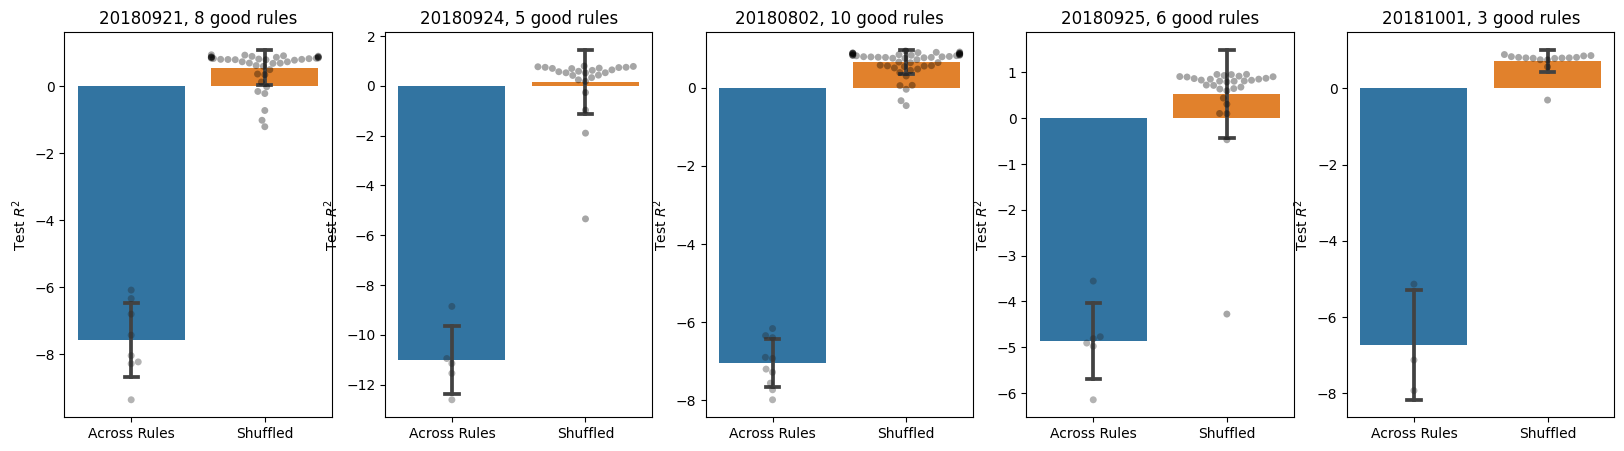

In [51]:
sesses = res.sort_values(by="EntropyScore", ascending=False)[1:6]
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

num_shuffles = 5
for i, (_, row) in enumerate(sesses.iterrows()):
    session = row.session_name
    beh, agg = get_beh_fr(session)
    beh = behavioral_utils.filter_max_feat_correct(beh)

    fake_agg = beh[["TrialNumber"] + [f"{feat}Value" for feat in FEATURES]]
    rename_map = {f"{feat}Value": i for i, feat in enumerate(FEATURES)}
    fake_agg = fake_agg.rename(columns=rename_map)
    fake_agg = pd.melt(fake_agg, id_vars=["TrialNumber"], value_vars=list(range(12)), var_name="UnitID", value_name="FiringRate")

    counts = beh.groupby("CurrentRule").BlockNumber.nunique()
    good_rules = counts[counts >=3].index
    beh = beh[beh.CurrentRule.isin(good_rules)]
    print(f"{session}, {len(good_rules)}")

    across_rules = get_rule_generalizability(beh, fake_agg)
    
    shuffles = []
    for shuffle_idx in range(num_shuffles):
        beh = behavioral_utils.shuffle_block_rules(beh, seed=shuffle_idx)
        shuffles += get_rule_generalizability(beh, fake_agg)


    ax = axs[i]
    visualization_utils.visualize_accuracy_bars(
        [across_rules, shuffles], 
        ["Across Rules", "Shuffled"], 
        ax=ax
    )
    ax.set_ylabel("Test $R^2$")
    ax.set_title(f"{session}, {len(good_rules)} good rules")

### Plot some correlations

In [46]:
session = 20180802
beh, agg = get_beh_fr(session)
beh = behavioral_utils.filter_max_feat_correct(beh)
triangle_beh = beh[beh.CurrentRule == "TRIANGLE"]

In [47]:
beh.groupby("CurrentRule").BlockNumber.nunique()

CurrentRule
CIRCLE      6
CYAN        6
ESCHER      1
GREEN       6
MAGENTA     3
POLKADOT    4
RIPPLE      4
SQUARE      5
STAR        2
SWIRL       4
TRIANGLE    7
YELLOW      5
Name: BlockNumber, dtype: int64

In [48]:
feat_val_names = [f"{f}Value" for f in FEATURES]
y = triangle_beh.MaxValue
x = triangle_beh[feat_val_names]
model = LinearRegression()
model = model.fit(x, y)
print(model.score(x, y))
print(model.coef_)

1.0
[ 2.02246476e-16 -9.99200722e-16 -3.67761377e-16  1.00000000e+00
  4.30211422e-16 -2.49800181e-16  5.82867088e-16 -1.38777878e-17
  3.33066907e-16  0.00000000e+00  4.51028104e-16  3.33066907e-16]


In [50]:
cyan_beh = beh[beh.CurrentRule == "CYAN"]
y = cyan_beh.MaxValue
x = cyan_beh[feat_val_names]
print(model.score(x, y))

-4.791947711889001


Text(0, 0.5, 'SQUARE')

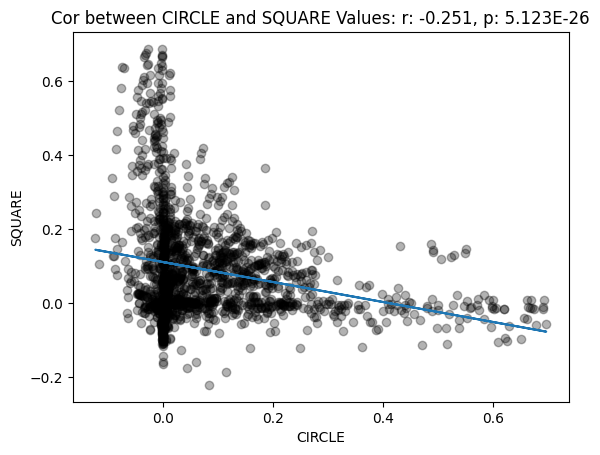

In [24]:
feat1 = "CIRCLE"
feat2 = "SQUARE"
fig, ax = plt.subplots()
slope, intercept, r_value, p_value, std_err = stats.linregress(beh[f"{feat1}Value"], beh[f"{feat2}Value"])
ax.scatter(beh[f"{feat1}Value"], beh[f"{feat2}Value"], alpha=0.3, color="black")
ax.plot(beh[f"{feat1}Value"], beh[f"{feat1}Value"] * slope + intercept)
ax.set_title(f"Cor between {feat1} and {feat2} Values: r: {r_value:.3f}, p: {p_value:.3E}")
ax.set_xlabel(feat1)
ax.set_ylabel(feat2)


Text(0, 0.5, 'CYAN')

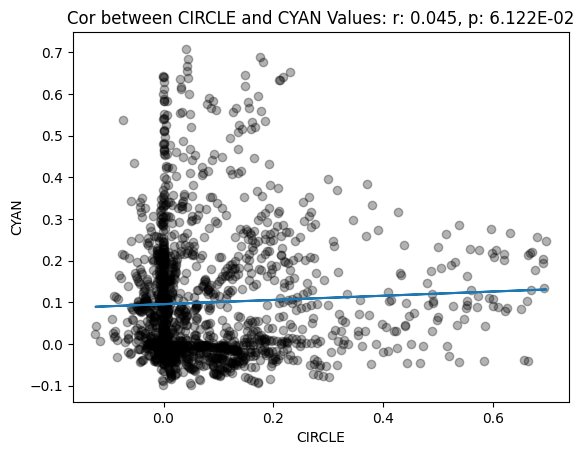

In [25]:
feat1 = "CIRCLE"
feat2 = "CYAN"
fig, ax = plt.subplots()
slope, intercept, r_value, p_value, std_err = stats.linregress(beh[f"{feat1}Value"], beh[f"{feat2}Value"])
ax.scatter(beh[f"{feat1}Value"], beh[f"{feat2}Value"], alpha=0.3, color="black")
ax.plot(beh[f"{feat1}Value"], beh[f"{feat1}Value"] * slope + intercept)
ax.set_title(f"Cor between {feat1} and {feat2} Values: r: {r_value:.3f}, p: {p_value:.3E}")
ax.set_xlabel(feat1)
ax.set_ylabel(feat2)
